# LC25000-Lung Cancer Classification using ResNet50

In [1]:
import keras
print(keras.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

2.12.0


**Import Libraries**

In [2]:
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Dropout, Add
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense
from keras.utils import np_utils
#from keras.initializers import glorot_uniform
from keras import backend as K

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
import cv2
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import math

**Loading Folders from LC25000 Dataset**

In [4]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (80,80))
            images.append(img)
            
    return np.array(images)

In [5]:
benign = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n')
mal_aca = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca')
mal_scc = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc')

In [6]:
print(f"Number of images for every class: BENIGN {benign.shape[0]}, ADENOCARCINOMAS {mal_aca.shape[0]}, SQUAMOS CELL CARCINOMAS {mal_scc.shape[0]}.")

Number of images for every class: BENIGN 5000, ADENOCARCINOMAS 5000, SQUAMOS CELL CARCINOMAS 5000.


In [7]:
print(f"Images shape: {benign[0].shape}.")

Images shape: (80, 80, 3).


In [8]:
samples = np.concatenate((benign, mal_aca, mal_scc))
labels = np.array(benign.shape[0] * [0] + mal_aca.shape[0] * [1] + mal_scc.shape[0] * [2])

In [9]:
indices = np.arange(samples.shape[0])
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]

# normalize pictures
samples = samples.astype('float32') / 255

**Train Test Split**

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size = 0.2)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

In [11]:
Y_train = np_utils.to_categorical(y_train, 3)
Y_val = np_utils.to_categorical(y_val, 3)
Y_test = np_utils.to_categorical(y_test, 3)


# **ResNet50**

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, stride=1):
    identity = x
    x = layers.Conv2D(filters[0], (1, 1), strides=stride, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters[1], (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters[2], (1, 1))(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or identity.shape[-1] != filters[2]:
        identity = layers.Conv2D(filters[2], (1, 1), strides=stride)(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.add([x, identity])
    x = layers.Activation('relu')(x)
    return x

def ResNet50(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, [64, 64, 256], stride=1)
    x = residual_block(x, [64, 64, 256])
    x = residual_block(x, [128, 128, 512], stride=2)
    x = residual_block(x, [128, 128, 512])
    x = residual_block(x, [256, 256, 1024], stride=2)
    x = residual_block(x, [256, 256, 1024])
    x = residual_block(x, [256, 256, 1024])
    x = residual_block(x, [256, 256, 1024])
    x = residual_block(x, [512, 512, 2048], stride=2)
    x = residual_block(x, [512, 512, 2048])
    x = layers.GlobalAveragePooling2D()(x)

    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(input_layer, output_layer)
    return model

In [13]:
input_shape = (80, 80, 3)  
num_classes = 3  
model_2 = ResNet50(input_shape, num_classes)
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 40, 40, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 40, 40, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 40, 40, 64)   0           ['batch_normalization[0][0]']

In [14]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

history = model_2.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
188/188 [==============================] - 558s 3s/step - loss: 0.3560 - accuracy: 0.8796 - val_loss: 16.3891 - val_accuracy: 0.3527
Epoch 2/10
188/188 [==============================] - 543s 3s/step - loss: 0.1503 - accuracy: 0.9434 - val_loss: 4.5036 - val_accuracy: 0.3700
Epoch 3/10
188/188 [==============================] - 542s 3s/step - loss: 0.1157 - accuracy: 0.9581 - val_loss: 0.7105 - val_accuracy: 0.8427
Epoch 4/10
188/188 [==============================] - 539s 3s/step - loss: 0.0942 - accuracy: 0.9657 - val_loss: 0.7330 - val_accuracy: 0.8293
Epoch 5/10
188/188 [==============================] - 538s 3s/step - loss: 0.0672 - accuracy: 0.9759 - val_loss: 2.6264 - val_accuracy: 0.6300
Epoch 6/10
188/188 [==============================] - 539s 3s/step - loss: 0.0472 - accuracy: 0.9822 - val_loss: 4.6073 - val_accuracy: 0.5393
Epoch 7/10
188/188 [==============================] - 538s 3s/step - loss: 0.0631 - accuracy: 0.9783 - val_loss: 0.3527 - val_accuracy: 0.892

/tmp/ipykernel_32/3116035815.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


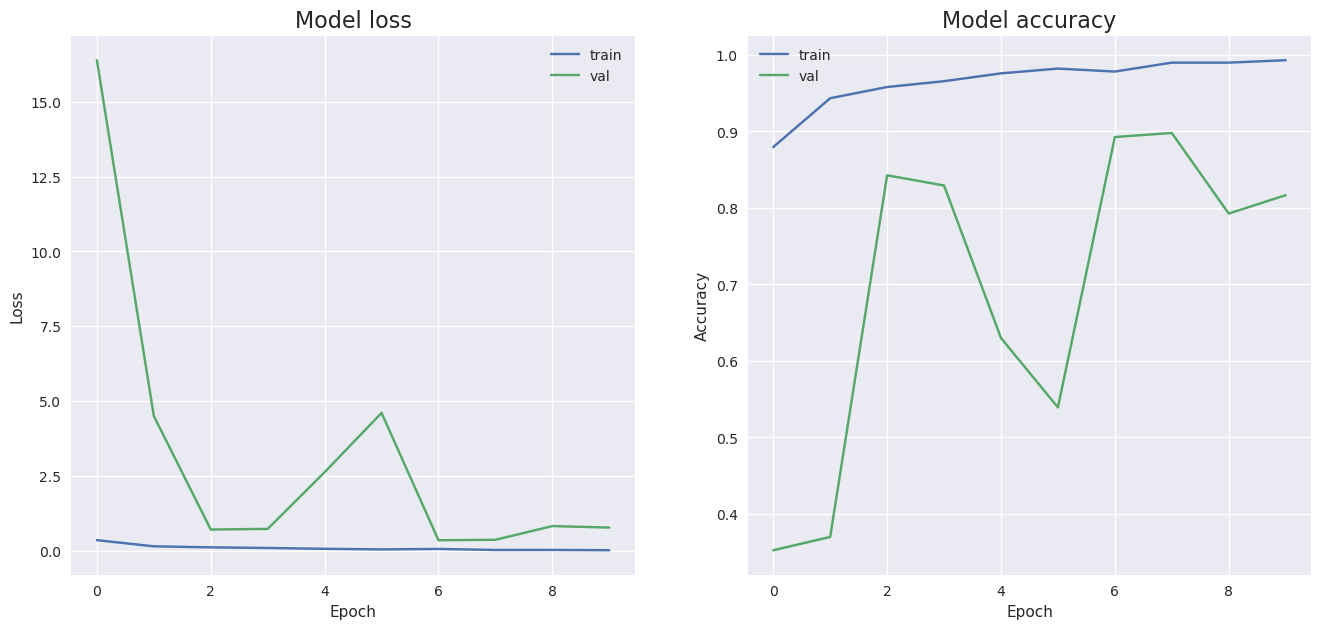

In [15]:
plt.style.use('seaborn')
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model loss', fontsize=16)  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model accuracy', fontsize=16)  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.show()

In [16]:
y_pred_test = model_2.predict(X_test, verbose=1)
y_pred_train = model_2.predict(X_train, verbose=1)

# conversion to one hot encoding
#y_pred_test = (y_pred_test > 0.5).astype("int32")
#y_pred_train = (y_pred_train > 0.5).astype("int32")

# convert it to numerical classes
y_pred_test = np.argmax(y_pred_test, axis=1)
y_pred_train = np.argmax(y_pred_train, axis=1)

score_test = model_2.evaluate(X_test, Y_test)
print(f"Train accuracy: {history.history['accuracy'][-1]:.3f}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]:.3f}")
print(f"Test accuracy: {score_test[1]:.3f}")

47/47 [==============================] - 11s 228ms/step - loss: 0.6431 - accuracy: 0.8413
Train accuracy: 0.993
Validation accuracy: 0.817
Test accuracy: 0.841


<Axes: >

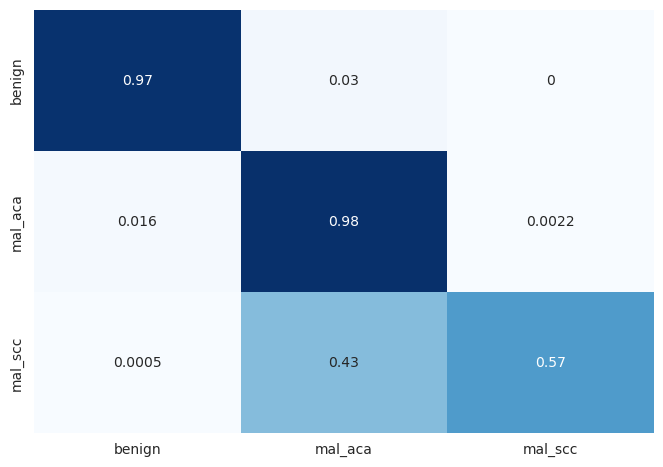

In [17]:
label_names = ['benign', 'mal_aca', 'mal_scc']


confmat = confusion_matrix(y_train, y_pred_train, normalize='true')
sn.heatmap(confmat, annot=True, cmap='Blues', cbar=False, 
           xticklabels=label_names, yticklabels=label_names)

In [18]:
from sklearn.metrics import confusion_matrix, classification_report


# Classification report for training set
classification_report_train = classification_report(y_train, y_pred_train, target_names=label_names)

# Classification report for testing set
classification_report_test = classification_report(y_test, y_pred_test, target_names=label_names)

print("Training Set Classification Report:\n")
print(classification_report_train)

print("Testing Set Classification Report:\n")
print(classification_report_test)

Training Set Classification Report:

              precision    recall  f1-score   support

      benign       0.98      0.97      0.98      3997
     mal_aca       0.68      0.98      0.81      4018
     mal_scc       1.00      0.57      0.73      3985

    accuracy                           0.84     12000
   macro avg       0.89      0.84      0.84     12000
weighted avg       0.89      0.84      0.84     12000

Testing Set Classification Report:

              precision    recall  f1-score   support

      benign       0.99      0.97      0.98       521
     mal_aca       0.68      0.99      0.80       493
     mal_scc       1.00      0.55      0.71       486

    accuracy                           0.84      1500
   macro avg       0.89      0.84      0.83      1500
weighted avg       0.89      0.84      0.84      1500



In [19]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Get true classes for test and train datasets
y_true_test = np.argmax(Y_test, axis=1)
y_true_train = np.argmax(Y_train, axis=1)

# Calculate precision, recall, and F1 score for test and train datasets
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average='weighted')
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_true_train, y_pred_train, average='weighted')

# Print the results
print("Test set metrics:")
print(f"Precision: {precision_test:.3f}")
print(f"Recall: {recall_test:.3f}")
print(f"F1 Score: {f1_score_test:.3f}")

print("\nTrain set metrics:")
print(f"Precision: {precision_train:.3f}")
print(f"Recall: {recall_train:.3f}")
print(f"F1 Score: {f1_score_train:.3f}")


Test set metrics:
Precision: 0.889
Recall: 0.841
F1 Score: 0.835

Train set metrics:
Precision: 0.887
Recall: 0.842
F1 Score: 0.836


**Mistakes**

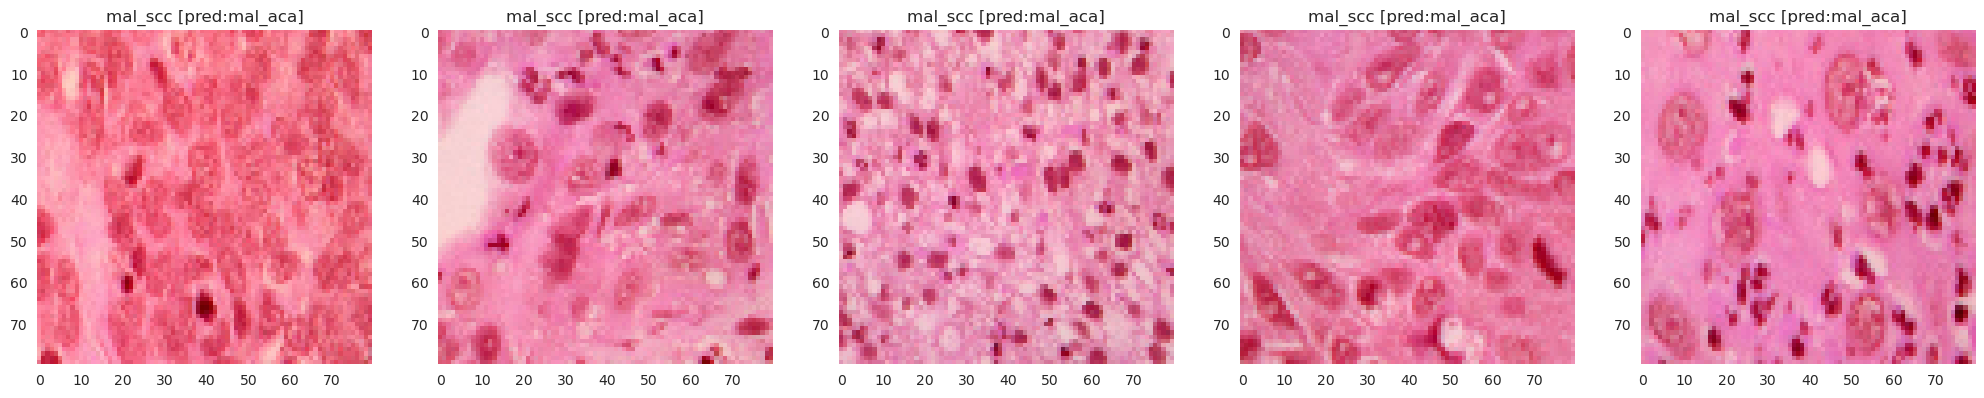

In [20]:
mistakes = np.where(y_pred_train != y_train)[0]

n = 5

plt.figure(figsize=(5 * n, 5))

# get 5 random false negatives
for i, val in enumerate(np.random.choice(mistakes, n)):

    plt.subplot(1, n, i + 1)
    plt.imshow(X_train[val])
    plt.title(f"{label_names[y_train[val]]} [pred:{label_names[y_pred_train[val]]}]", fontsize=12)
    plt.grid(None)

